## Optimizing RecoX

This notebook first generates one flash and one track pair. To reconstruct the "true" x position of track within the detector volume, we loop over the volume and systematically place the track at each location. At each location, we generate a predicted flash using an optical signal transport model (either photon library or SIREN) and compute the negative log likelihood between this predicted flash and our observed flash. We select the x position resulting in the maximum value for negative log likelihood (minimizing loss).

In [4]:
import numpy as np
import yaml, torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display

from pfmatch import DataGen
from pfmatch import Manager
from pfmatch.photonlib.photon_library import PhotonLibrary
from pfmatch.algorithm.match_model import PoissonMatchLoss, GradientModel

In [5]:
# Configurations
det_yaml='../data/config/detector_specs.yml'
det_cfg = yaml.load(open(det_yaml), Loader=yaml.Loader)['DetectorSpecs']
gen_yaml='../data/config/flashmatch.yml'
gen_cfg = yaml.load(open(gen_yaml), Loader=yaml.Loader)

In [6]:
# Data generator instantiated with photonlibrary
plib = PhotonLibrary('../plib.h5')
generator = DataGen(det_cfg, gen_cfg, plib)

# Manager instantiated with photon library
mgr = Manager(det_yaml, gen_yaml, plib)

# Loss calculator 
loss_fn = PoissonMatchLoss()

Flash (PMT v.s. PE)


/Users/youngsam/Code/slac_dune/icarus-summer-2023/pfmatch/data_gen.py:230: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flash.pe_v = torch.tensor(pe_v,device=pe_v.device)


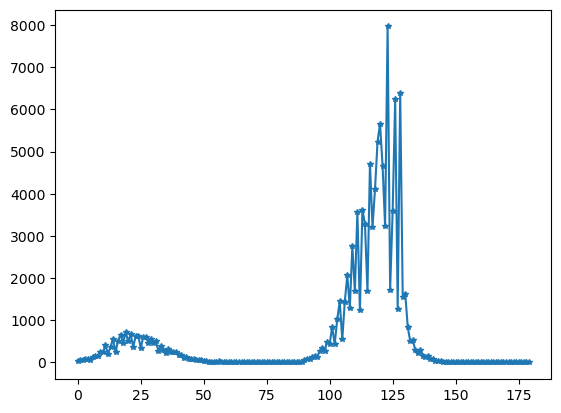

Trajectory 3D points


In [7]:
#Generating one flash-match pair of qcluster and flash
pair = generator.make_flashmatch_inputs(1)

# Plot a flash 
print('Flash (PMT v.s. PE)')
truth_flash = pair.flash_v[0]
plt.plot(np.arange(truth_flash.pe_v.shape[0]),truth_flash.pe_v.cpu().numpy(),marker='*',markersize=4)
plt.show()

# Visualize a Track
print('Trajectory 3D points')
qc = pair.qcluster_v[0]
pts=qc.qpt_v.cpu().numpy()
trace=go.Scatter3d(x=pts[:,0],y=pts[:,1],z=pts[:,2])
fig=go.Figure()
fig.add_trace(trace)
fig.show()

## Calculating Loss Value for True Track
We know the true x-position because we generated the data

In [8]:
print("loss for true track")
flashhypothesis = generator.make_flash(pair.qcluster_v[0])
print(loss_fn(pair.flash_v[0].pe_v, flashhypothesis.pe_v))

loss for true track
tensor(977.5929, dtype=torch.float64)


/Users/youngsam/Code/slac_dune/icarus-summer-2023/pfmatch/data_gen.py:230: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




  ### Input: params (tuple of (qcluster, flash))
  ### Output: loss, x_reco, pe_reco
  
  ### Steps to optimize x shift with torch:
    - calculate initial shift to place track at min of active volume, total shift, etc.
    - calculate integral factor to reweight flash based on time??
    - loop to minimize loss, calling train method in pfmatch.manager which sets up torch optimizer


In [9]:
# Record the true boundary x values that include the trajectory
qc_xmin = qc.qpt_v[:,0].min().item()
qc_xmax = qc.qpt_v[:,0].max().item()
print(f'The trajectory spans X = [{qc_xmin}, {qc_xmax}]')

# Get the active volume bounds along the x-axis
active_xmin = det_cfg['ActiveVolumeMin'][0]
active_xmax = det_cfg['ActiveVolumeMax'][0]
print(f'The active volume spans X = [{active_xmin}, {active_xmax}]')

# Figure out the shift.
# 1. calculate the lowest x position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest x position to shift (where the trajectory touches the active volume maximum)
shift_init  = qc_xmin - active_xmin
shift_total = (active_xmax - active_xmin) - (qc_xmax - qc_xmin)
print('Will shift the x-position of the trajectory by:', shift_init)
print('Then move the trajectory up to:', shift_total)

# Step 4 , scan the loss value
NSTEPS_X = 100 # number of samples along x axis
dx_one = shift_total/NSTEPS_X # the step size to move the trajectory along x

#Variables
dx_min = active_xmin - qc_xmin
dx_max = active_xmax - qc_xmax
dx_v = []
for n in np.arange(NSTEPS_X):
    dx_v.append(n * dx_one)

The trajectory spans X = [-105.90012208815074, 23.64117582444692]
The active volume spans X = [-358.49, -61.94]
Will shift the x-position of the trajectory by: 252.58987791184927
Then move the trajectory up to: 167.00870208740236


## Optimizing Step

In [10]:
print('curr xmin:', qc.qpt_v[:, 0].min().item())
#initial shift
qc.qpt_v[:, 0] -= shift_init

print('xmin after shift:', qc.qpt_v[:, 0].min().item())

NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X # the step size to move the trajectory along x
loss_v=[] # a list to store the computed loss values in the loop below
x_v = []

# Loop over NSTEPS, apply dx, compute the loss
for i in range(NSTEPS_X):
    # shift
    qc.qpt_v[:,0] += dx_one
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_v.append(loss.cpu().item())
    x_v.append(qc.qpt_v[:, 0].min().item())

#Resetting X shift
qc.qpt_v[:, 0] -= shift_total
print(qc.qpt_v[:, 0].min().item())

curr xmin: -105.90012208815074
xmin after shift: -358.49
-358.4900000000006


In [13]:
# Apply the initial shift
def one_match(params):
    res = []
    qc, flash = params
    
    if not np.allclose(qc.qpt_v[:,0].min().item(), active_xmin):
        qc.qpt_v[:,0] -= (qc.qpt_v[:,0].min().item() - active_xmin)

    input = qc.qpt_v
    #target = flash.pe_v / integral_factor
    target = flash.pe_v
    
    return mgr.train(input, target, dx, 0, dx_max-dx_min)

In [14]:
result = one_match((pair.qcluster_v[0], pair.flash_v[0]))

## Plotting Optimization
Reconstructing x position (detector depth) using negative log likelihood 

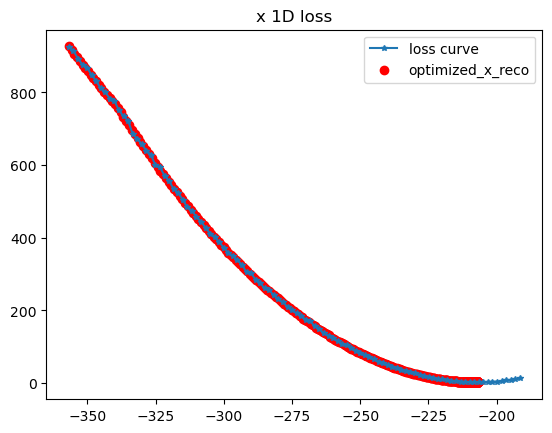

In [15]:
plt.plot(x_v,loss_v,marker='*',markersize=4)
plt.scatter(result[-1], result[-2], color='red', label='x_rxeco')
plt.legend(["loss curve", "optimized_x_reco"])
plt.title("x 1D loss")
plt.show()